<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/TCC_MDC_Fer_com_crop_poneis_malditos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plant Pathology Classification

# Setup


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import random
from PIL import Image
from matplotlib import image

import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.keras.metrics import Recall, SpecificityAtSensitivity
from tensorflow.python.ops import math_ops
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Flatten, Dropout,
    GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, MaxPool2D
)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate

from sklearn.metrics import (
    confusion_matrix, classification_report,
    balanced_accuracy_score
)

from google.colab import files
from google.colab import drive

     |████████████████████████████████| 1.1 MB 6.9 MB/s 


# 01 - Carregando das imagens

In [2]:
# Necessario usar chave do kaggle nesse pedaço de codigo
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielnkurosawa","key":"e14ec3565c33f27af7e8faf8e96488b8"}'}

In [3]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=cdb37b4d8d772fa8c091248fc29d1f1fbe352f731415bbaaf1e7e69abf55b030
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! mkdir dataset

In [5]:
! kaggle competitions download -c plant-pathology-2021-fgvc8 -p '/content/dataset'


100% 14.9G/14.9G [02:42<00:00, 69.1MB/s]
100% 14.9G/14.9G [02:42<00:00, 98.3MB/s]


In [6]:
! unzip '/content/dataset/plant-pathology-2021-fgvc8.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train_images/e00c97b2de4749ce.jpg  
  inflating: /content/dataset/train_images/e00df890cfe62736.jpg  
  inflating: /content/dataset/train_images/e00ed0bf43a87f25.jpg  
  inflating: /content/dataset/train_images/e00f759d65d52887.jpg  
  inflating: /content/dataset/train_images/e00f934d9e50ad5b.jpg  
  inflating: /content/dataset/train_images/e00fce341cb63da5.jpg  
  inflating: /content/dataset/train_images/e010c7c35ecf3d1c.jpg  
  inflating: /content/dataset/train_images/e01112939f783fec.jpg  
  inflating: /content/dataset/train_images/e01592da4d71b8be.jpg  
  inflating: /content/dataset/train_images/e0189acaf8cf80fd.jpg  
  inflating: /content/dataset/train_images/e0189e4999bdd0fa.jpg  
  inflating: /content/dataset/train_images/e01ae16d4a759cb5.jpg  
  inflating: /content/dataset/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: /content/dataset/train_images/e01e42d90c66f3f3.jpg  
  inflating: /content/dat

In [7]:
train_image_path = './dataset/train_images'
test_image_path = './dataset/test_images'
train_df_path = './dataset/train.csv'
test_df_path = './dataset/sample_submission.csv'
TRAIN_PATH = './dataset/train_images/'
TEST_PATH = './dataset/test_images/'


In [ ]:
df_train = pd.read_csv(train_df_path)
df_test= pd.read_csv(test_df_path)

In [ ]:

df_test

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


# Carregamento de Dados



## Recarregamento de Dados - Importar csv

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
del(df_train, df_test)

NameError: ignored

In [9]:
df_train = pd.read_csv('./drive/MyDrive/TFG-unicamp/df_train_exif.csv')
df_test = pd.read_csv('./drive/MyDrive/TFG-unicamp/df_test_exif.csv')

In [ ]:
df_train

## Carregamento de Dados - Reading EXIF from images

In [ ]:
import hashlib
from tqdm.notebook import tqdm
import hashlib

In [ ]:
df_test

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [ ]:
def ret_calculate_hash(img_matx):
    md5 = hashlib.md5()
    md5.update(np.array(img_matx).tostring())
    
    return md5.hexdigest()

In [ ]:
def ret_dict_meta(image_name, path = TRAIN_PATH):
    img_o = Image.open(path+image_name)
    extrema = img_o.getextrema()
    meta = {
    'image': image_name,
    'dataset': path.split('/')[-2],
    'hash':  ret_calculate_hash(img_o),
    'r_min': extrema[0][0],
    'r_max': extrema[0][1],
    'g_min': extrema[1][0],
    'g_max': extrema[1][1],
    'b_min': extrema[2][0],
    'b_max': extrema[2][1],
    'height': img_o.size[0],
    'width': img_o.size[1],
    'format': img_o.format,
    'mode': img_o.mode
    }
    return meta

NameError: ignored

In [ ]:
ret_dict_meta(df_test['image'][0], path = TEST_PATH)

In [ ]:
lst_test = []

for i, image_name in enumerate(tqdm(df_test['image'].values, total = df_test.shape[0])):
  #print(image_name)
  lst_test.append(ret_dict_meta(image_name, path = TEST_PATH))

In [ ]:
df_test_exif = pd.DataFrame(lst_test)
#df_test_exif

In [ ]:
df_test = pd.merge(df_test,df_test_exif, how='left', on = 'image')
df_test

In [ ]:
lst_train = []

for i, image_name in enumerate(tqdm(df_train['image'].values, total = df_train.shape[0])):
  #print(image_name)
  lst_train.append(ret_dict_meta(image_name, path = TRAIN_PATH))

In [ ]:
df_train_exif = pd.DataFrame(lst_train)
#df_train_exif

In [ ]:
df_train = pd.merge(df_train,df_train_exif, how='left', on = 'image')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_test.to_csv('./drive/MyDrive/TFG-unicamp/df_test_exif.csv', index = False)
df_train.to_csv('./drive/MyDrive/TFG-unicamp/df_train_exif.csv', index = False)

# Análise exploratória dos dados

## 03.01 - Análise das labels



In [ ]:
df_train.labels.value_counts()


scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

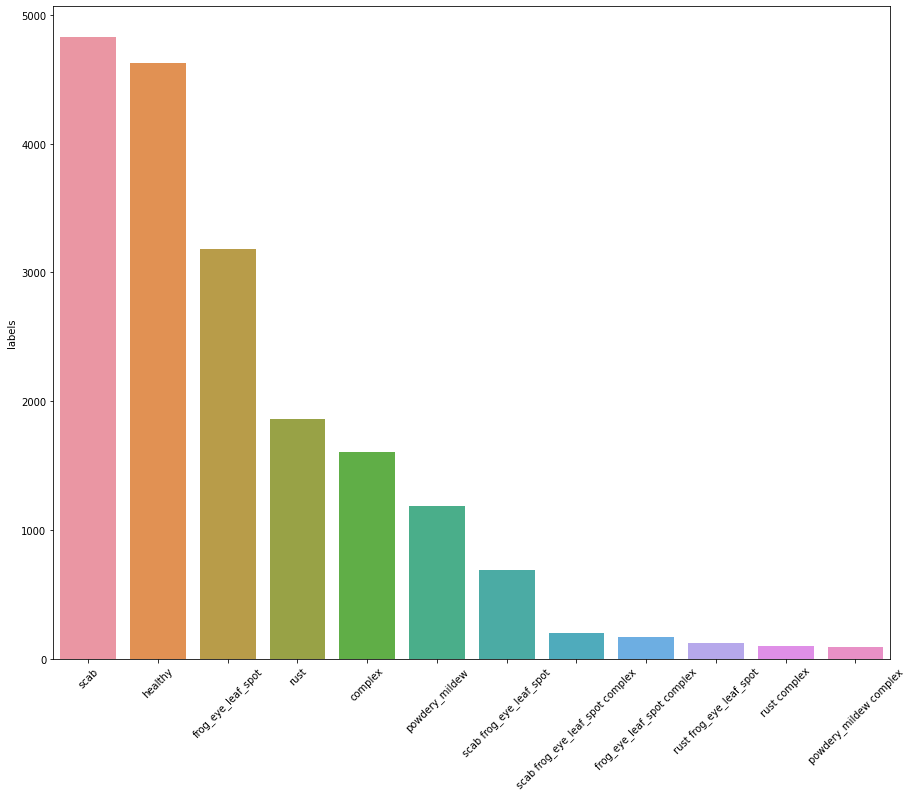

In [ ]:
plt.figure(figsize=(15,12))
labels = sns.barplot(df_train.labels.value_counts().index,df_train.labels.value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

In [ ]:
df_train_count = df_train.groupby('labels').sum()['qtd'].reset_index()

In [ ]:
df_train_mean = df_train.groupby('labels').mean()[['r_min', 'r_max', 'g_min', 'g_max', 'b_min', 'b_max', 'height', 'width',]].reset_index()

In [ ]:
df_train_status = pd.merge(df_train_mean, df_train_count, how = 'left', on = 'labels')
df_train_status.sort_values('qtd', ascending= False)
df_train_status.index = df_train_status['labels']
df_train_status = df_train_status[['r_min', 'r_max', 'g_min', 'g_max', 'b_min', 
                                   'b_max','height', 'width', 'qtd']]
df_train_status = df_train_status

,r_min,r_max,g_min,g_max,b_min,b_max,height,width,qtd
labels,,,,,,,,,
complex,23.636536,254.742731,35.716182,254.813527,2.814791,253.005689,3943.130215,2658.331226,1582
frog_eye_leaf_spot,15.950644,254.047784,31.691606,254.916693,0.978937,252.114744,4000.000000,2672.618673,3181
frog_eye_leaf_spot complex,28.515152,254.739394,42.981818,254.927273,5.484848,252.757576,4000.000000,2673.987879,165
healthy,16.139057,253.006488,39.677552,254.759299,1.605104,253.209559,3999.695502,2694.069204,4624
powdery_mildew,18.960304,251.369932,32.877534,254.094595,4.714527,251.328547,4000.000000,2675.324324,1184
powdery_mildew complex,19.471264,254.505747,33.080460,254.977011,4.114943,253.022989,4000.000000,2754.942529,87
rust,14.799782,253.917621,23.921986,252.877796,1.863612,251.379160,3502.498636,2394.378614,1833
rust complex,20.153846,254.406593,27.516484,253.087912,1.923077,251.241758,3845.274725,2651.164835,91
rust frog_eye_leaf_spot,22.941176,254.235294,30.672269,252.134454,2.512605,248.949580,3611.697479,2423.327731,119


### Plottando Images

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [ ]:
TRAIN_PATH = './dataset/train_images/'
TEST_PATH = './dataset/test_images/'

In [ ]:
def plot_image(image_name, path = TRAIN_PATH, figsize = (410,272)):
  if path == TRAIN_PATH:
    label = df_train[df_train['image'] == image_name]['labels'].item()
    
  elif path == TEST_PATH:
    label = df_test[df_test['image'] == image_name]['labels'].item()
    
  
  fig = px.imshow(cv2.resize(ret_img(image_name, path), figsize))
  fig.update_layout(
    title="{} - {}".format(label, image_name)
    )

  
  
  fig.show()


### **Plotar Exemplos ou Amostra de Exemplos** 

https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch

na parte:

"Let see the Plant pathology Images"

In [ ]:
len(df_train['labels'].unique())

12

In [ ]:
def ret_img(image_name, path = TRAIN_PATH):
  img = image.imread(path + image_name)
  return img

In [ ]:
plot_image(df_train['image'][1], path = TRAIN_PATH, figsize = (410,272))

## 03.02 - Análise do dataframe

### Duplicatas

In [ ]:
df_train['image'].value_counts()

e595251f394a98ae.jpg    1
d08ec37ee1642376.jpg    1
976e1ec60dcb023d.jpg    1
d1bc99ca2f01e61b.jpg    1
defe7e9568880138.jpg    1
                       ..
88e21dc2dedcc69c.jpg    1
f8d4c9c2051f24fd.jpg    1
9235e2d28b7aed48.jpg    1
b235de10677b58b0.jpg    1
a501cbd8bd497366.jpg    1
Name: image, Length: 18632, dtype: int64

In [ ]:
df_count_hash = pd.DataFrame(df_train['hash'].value_counts()).reset_index()
df_count_hash = df_count_hash.rename(columns = {'hash':'qtd'})
df_count_hash = df_count_hash.rename(columns = {'index':'hash'})
df_count_hash

,hash,qtd
0,56c923f76846802e54317cf3163d26b4,2
1,ec8e62e066338b14b1bb6ad3e799a66b,2
2,648689a1ad9d7a40ac1746f2eebf2c3d,2
3,28828edc5c2b601fdee0b35c20272190,2
4,22f4ce30e3a744c483d8e70e48a43387,2
...,...,...
18600,0e785a999b3fc519bc7e7f1e2a56cc9b,1
18601,09cb1a50131710a38c65993b56bf10c4,1
18602,e046edb9d1609dfbc17e9692c83c717c,1
18603,51aab6bc933b52d3bbf4741a24d9b130,1


In [ ]:
df_train = pd.merge(df_train, df_count_hash, how = 'left' , on = ['hash'])

In [ ]:
df_dup = df_train[df_train['qtd'] == 2]
df_dup

,image,labels,dataset,hash,r_min,r_max,g_min,g_max,b_min,b_max,height,width,format,mode,qtd
410,82ba3e933947b097.jpg,rust complex,train_images,46e022bc2ea8de0999585f2f1d8ed7eb,19,255,12,225,6,220,2592,1728,JPEG,RGB,2
630,848d9f9e82d18e5e.jpg,rust,train_images,7b587dc3560c5aa0c448982865f9ccf4,22,230,21,239,0,228,2592,1728,JPEG,RGB,2
786,85897ea7f064b26a.jpg,complex,train_images,e1e33c87f09761d4b200d56b0ee84cac,18,229,28,221,5,202,2592,1728,JPEG,RGB,2
995,86f963a16e70345e.jpg,rust complex,train_images,df1af10a37d5bf0b05c3212f9203aeb3,40,255,29,225,3,249,2592,1728,JPEG,RGB,2
1567,8c0731fff680c51e.jpg,rust,train_images,7784f165eb2fcef8f0660e9797f5bc6e,23,233,21,232,9,220,2592,1728,JPEG,RGB,2
1901,8f5263c61a8cdbe2.jpg,rust,train_images,c6ef25141808cdb968cb563d3085c9f7,13,209,29,212,6,197,2592,1728,JPEG,RGB,2
2045,90a5341f227ce5f9.jpg,complex,train_images,cd816b0a2e288881d4dfb24efafa97ee,3,199,21,215,0,201,2592,1728,JPEG,RGB,2
2124,90f99ee1c1132bb6.jpg,rust,train_images,b3d7b937930190addd70de088d65f631,25,255,40,237,0,235,2592,1728,JPEG,RGB,2
2528,949b6595a5b8ca3c.jpg,complex,train_images,7b587dc3560c5aa0c448982865f9ccf4,22,230,21,239,0,228,2592,1728,JPEG,RGB,2
2557,94b42695f24dad36.jpg,complex,train_images,c26e3c3184a0f6e7e0074c37e6558948,0,255,5,229,0,211,2592,1728,JPEG,RGB,2


### Plottando duplicates

In [ ]:
df_train[df_train['hash'] == 'c5d423bf75d28f32a79100850e4587c1'].reset_index(drop = True)['image'].loc[0]

'b7b0edd58a858217.jpg'

In [ ]:
def plot_duplicates(hash_plot, path = TRAIN_PATH):
  df_plot = df_train[df_train['hash'] == hash_plot].reset_index(drop = True)
  image_name_0 = df_plot['image'].loc[0]
  label_0 = df_plot['labels'].loc[0]
  image_name_1 = df_plot['image'].loc[1]
  label_1 = df_plot['labels'].loc[1]

  plt.figure(figsize=(9,4))
  plt.subplot(121)
  #n = lst_img[0]
  plt.imshow(ret_img(image_name_0 ,path= TRAIN_PATH))
  plt.title('{} - {}'.format(image_name_0, label_0))
  plt.subplot(122)
  #n = lst_img[1]
  plt.imshow(ret_img(image_name_1 ,path= TRAIN_PATH))
  plt.title('{} - {}'.format(image_name_1, label_1))
  plt.tight_layout()


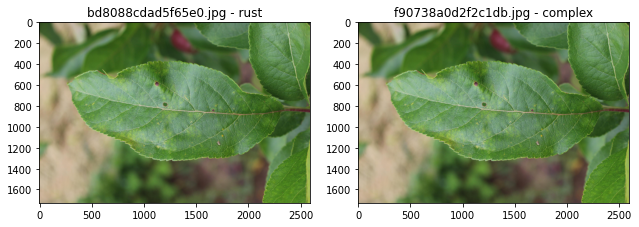

In [ ]:
plot_duplicates('ec8e62e066338b14b1bb6ad3e799a66b')

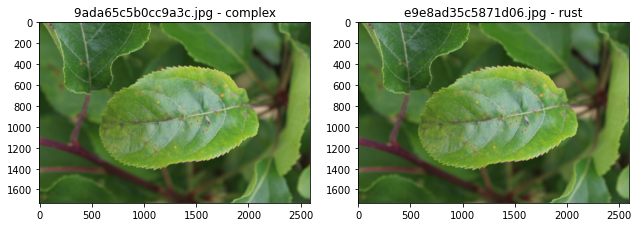

In [ ]:
plot_duplicates('61320a0a2bd07ee7d120b6688dd8f028')

Existem duplicatas com labes diferentes , verificando a quantidade de divergências

In [ ]:
def ret_diff(hash):
  df_l = df_dup[df_dup['hash'] == hash].reset_index(drop = True)
  if df_l['labels'].iloc[0] == df_l['labels'].iloc[1]:
    return 'igual'
  elif df_l['labels'].iloc[0] != df_l['labels'].iloc[1]:
    return 'diferente'



In [ ]:
df_dup['diff'] = df_dup['hash'].apply(ret_diff)
df_dup['diff'].value_counts()

diferente    54
Name: diff, dtype: int64

In [ ]:
df_dup['labels'].value_counts()

rust                       27
complex                    20
rust complex                6
rust frog_eye_leaf_spot     1
Name: labels, dtype: int64

In [ ]:
df_dup[df_dup['labels'] == 'rust frog_eye_leaf_spot']

,image,labels,dataset,hash,r_min,r_max,g_min,g_max,b_min,b_max,height,width,format,mode,qtd,diff
11752,d1dec0973c2cf4a1.jpg,rust frog_eye_leaf_spot,train_images,c6b45c05b3b526c990ef8433a2f441a7,29,255,29,238,0,227,2592,1728,JPEG,RGB,2,diferente


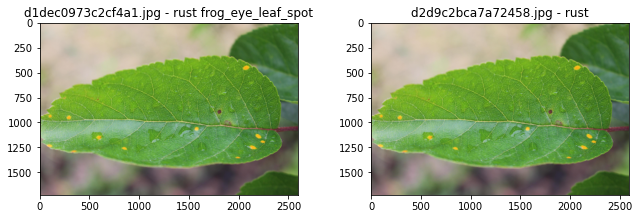

In [ ]:
plot_duplicates('c6b45c05b3b526c990ef8433a2f441a7')

## 03.03 - Análise do Tamanho

Fazer analise de tamanho para verificar qual melhor forma de resize

In [ ]:
df_test.to_csv('./drive/MyDrive/TFG-unicamp/df_test_exif.csv', index = False)
df_train.to_csv('./drive/MyDrive/TFG-unicamp/df_train_exif.csv', index = False)

# Preparação do Data Set

In [ ]:
CLASSES = np.asarray(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab'])
img_height = 256
img_width = 256
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
image_count = len(list(df_train.image))

In [ ]:
def prepare(df):
  df['target'] = df.labels.map(lambda e: np.in1d(CLASSES, e.split(' ')).astype('float32'))
  return df

prepare(df_train)

,image,labels,target
0,800113bb65efe69e.jpg,healthy,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0]"
2,80070f7fb5e2ccaa.jpg,scab,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,80077517781fb94f.jpg,scab,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,800cbf0ff87721f8.jpg,complex,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...
18627,fffb900a92289a33.jpg,healthy,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
18628,fffc488fa4c0e80c.jpg,scab,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
18629,fffc94e092a59086.jpg,rust,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
#Colocar de pandas df em tf dataset
#https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

In [ ]:
def format_path(image):
    return '/content/dataset/train_images/' + image

In [ ]:
train_paths = df_train['image'].apply(format_path).values

list_ds = tf.data.Dataset.from_tensor_slices((train_paths, np.vstack(df_train['target']).astype(np.float)))

#dividir em treino e validação
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path, labels):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, labels

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 6)), types: (tf.float32, tf.float64)>

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (128, 256, 256, 3)
Label:  [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 

In [ ]:
from PIL import Image
from matplotlib import image

def ret_img(image_name, path = TRAIN_PATH):
  img = image.imread(path + image_name)
  return img

In [ ]:


#based on https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch
def crop_leaf(img_name):
    img=ret_img(img_name, TRAIN_PATH)
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    row = np.argsort([coor[0] for coor in edge_coors])
    col = np.argsort([coor[1] for coor in edge_coors])
    row_min = edge_coors[row[0]][0]
    row_max = edge_coors[row[-1]][0]
    col_min = edge_coors[col[0]][1]
    col_max = edge_coors[col[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    # apagar linhas abaixo quando for usar como filtro (vale a pena deixar também na análise exploratória??)
    # fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    # ax[0].imshow(img, cmap='gray')
    # ax[0].set_title('Original Image', fontsize=24)
    # ax[1].imshow(edges, cmap='gray')
    # ax[1].set_title('Canny Edges', fontsize=24)
    # ax[2].imshow(new_img, cmap='gray')
    # ax[2].set_title('Cropped Image', fontsize=24)
    # plt.show()
    cv2.imwrite('/content/drive/MyDrive/cropped_images/'+img_name , new_img)

    # return new_img

In [ ]:
# !mkdir './drive/MyDrive/TFG-unicamp/cropped_images/'
!mkdir './drive/MyDrive/cropped_images/'


mkdir: cannot create directory ‘./drive/MyDrive/cropped_images/’: File exists


In [ ]:
import time
# df_train['image'][14]
start = time.time()
for image_name in df_train['image']:
  crop_leaf(image_name)
end = time.time()
print(end-start)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-0332f6a03c9e>", line 5, in <module>
    crop_leaf(image_name)
  File "<ipython-input-31-f2bfde7a528b>", line 11, in crop_leaf
    if edges[i][j] != 0:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offse

KeyboardInterrupt: ignored

# 04 - Baseline

Vamos pegar a saída da ResNet50 após todas as convoluções, congelar os pesos, e adicionar uma camada densa treinável para as novas classes do CIFAR-10. Podemos pensar nas camadas congeladas como extrator de características.


## 01 - Baseline

In [ ]:
F1_score = tfa.metrics.F1Score(
    num_classes= len(CLASSES),
    average = 'weighted',
)

In [ ]:
#pre processar os dados, o keras espera entre -1 e 1, colcoar uma camada de pre processamento -> rescalling(escala e offset) -> kera layer preprocessing
#tentar diminuir o tamanho da imagem (128, 128)
#softmax não serve para multilabel, se um aumento a probabilidade->diminui as outras
#classificador multilabel 
#sigmoid faz classificação multilabel
#
#organização -> Setup, Dados, 


In [ ]:
#Baseline
model_baseline = Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(256, 256, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

model_baseline.add(Conv2D(16, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

model_baseline.add(Conv2D(16, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_baseline.add(Flatten())
model_baseline.add(Dense(len(CLASSES),activation='sigmoid'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[F1_score])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

In [ ]:
class InterruptingCallback(tf.keras.callbacks.Callback):
   def on_epoch_begin(self, epoch, logs=None):
     if epoch == 2:
       raise RuntimeError('Interrupting!')


In [ ]:
#!mkdir './drive/MyDrive/TFG-unicamp/temp'
backup = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir="./drive/MyDrive/TFG-unicamp/temp")
#stop_callback = InterruptingCallback()

In [ ]:
drive_path = './drive/MyDrive/TFG-unicamp'
filepath = f'{drive_path}/baseline_vanilla_sem_pesos.h5'

early_stop = EarlyStopping(monitor='f1_score',patience=10)

callback_list = [backup, early_stop]

steps_per_epoch = 2000/batch_size

history_model_baseline= model_baseline.fit(train_ds,steps_per_epoch=steps_per_epoch,
                                           epochs = 64, batch_size = batch_size,                                        
                                           validation_data= val_ds,)
                                           #callbacks = callback_list)

Epoch 1/64
15/15 [==============================] - 128s 7s/step - loss: 12.7345 - f1_score: 0.2212 - val_loss: 2.4151 - val_f1_score: 0.1713
Epoch 2/64
15/15 [==============================] - 32s 2s/step - loss: 1.5052 - f1_score: 0.2220 - val_loss: 0.6590 - val_f1_score: 0.1845
Epoch 3/64
15/15 [==============================] - 36s 2s/step - loss: 0.5654 - f1_score: 0.2266 - val_loss: 0.5011 - val_f1_score: 0.1678
Epoch 4/64
15/15 [==============================] - 36s 2s/step - loss: 0.4678 - f1_score: 0.2368 - val_loss: 0.4601 - val_f1_score: 0.1914
Epoch 5/64
15/15 [==============================] - 36s 2s/step - loss: 0.4521 - f1_score: 0.2229 - val_loss: 0.4516 - val_f1_score: 0.1998
Epoch 6/64
15/15 [==============================] - 37s 2s/step - loss: 0.4439 - f1_score: 0.2407 - val_loss: 0.4479 - val_f1_score: 0.2278
Epoch 7/64
15/15 [==============================] - 28s 2s/step - loss: 0.4384 - f1_score: 0.2726 - val_loss: 0.4463 - val_f1_score: 0.2329
Epoch 8/64
15/15 [

## Resnet com imagenet

In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3)) # 32 x 32 (?)
#model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

In [ ]:
# Insere novas camadas no fim da rede para classificação
frozen_model = tf.keras.Sequential([
  #tf.keras.Input(shape = (256,256,3)),
  tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1, input_shape=(img_height, img_width, 3)),
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(CLASSES), activation='sigmoid')
])

frozen_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)


# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


frozen_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=sgd, metrics=[F1_score])

frozen_model.fit(train_ds, epochs=100, callbacks=[early],
                  validation_data=val_ds)

NameError: ignored

In [ ]:
# Insere novas camadas no fim da rede para classificação
frozen_model_without_rescaling = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(CLASSES), activation='sigmoid')
])

frozen_model_without_rescaling.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)


# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


frozen_model_without_rescaling.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=sgd, metrics=[F1_score])

frozen_model_without_rescaling.fit(train_ds, epochs=200, callbacks=[early],
                  validation_data=val_ds)

Epoch 1/200
117/117 [==============================] - 264s 2s/step - loss: 0.4433 - f1_score: 0.3213 - val_loss: 0.3970 - val_f1_score: 0.3908
Epoch 2/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3847 - f1_score: 0.4359 - val_loss: 0.3655 - val_f1_score: 0.5145
Epoch 3/200
117/117 [==============================] - 36s 306ms/step - loss: 0.3609 - f1_score: 0.5020 - val_loss: 0.3469 - val_f1_score: 0.5631
Epoch 4/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3457 - f1_score: 0.5412 - val_loss: 0.3345 - val_f1_score: 0.5951
Epoch 5/200
117/117 [==============================] - 36s 308ms/step - loss: 0.3352 - f1_score: 0.5665 - val_loss: 0.3249 - val_f1_score: 0.6158
Epoch 6/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3273 - f1_score: 0.5813 - val_loss: 0.3180 - val_f1_score: 0.6283
Epoch 7/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3210 - f1_score: 0.5949 - val_loss: 0.3119 - v

In [ ]:
#fazer o predict e calcular por classe - ver aulas de deep learning, calcular matriz de confusão
#usar o f1 balanceado - https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score - mesma coisa que acuraria e acuracia balanceada
#testar outros tipos de f1 (macro, micro)
#pesos nas classes (https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html)


# 05 - One vs All

###removendo duplicatas
Nesse caso como não somos especialistas vamos dropar qualquer coluna duplicada

In [ ]:
df_test = df_test.drop_duplicates('hash', keep = False).reset_index(drop = True)
df_train = df_train.drop_duplicates('hash', keep = False).reset_index(drop = True)

## 05.01 - Colocando coluna de labels

In [ ]:
df_train['labels'].value_counts().values

array([4826, 4624, 3181, 1833, 1582, 1184,  686,  200,  165,  119,   91,
         87])

In [ ]:
def ret_df_count_pct(df):
  df_count_pct_labels = pd.DataFrame(df['labels'].value_counts()/len(df))
  df_count_pct_labels['count'] = df['labels'].value_counts().values
  df_count_pct_labels = df_count_pct_labels[['count', 'labels']]
  df_count_pct_labels = df_count_pct_labels.rename(columns = {'labels':'pct'})
  return df_count_pct_labels

In [ ]:
df_pct_labels = ret_df_count_pct(df_train)
df_pct_labels

,count,pct
scab,4826,0.259770
healthy,4624,0.248897
frog_eye_leaf_spot,3181,0.171224
rust,1833,0.098665
complex,1582,0.085154
powdery_mildew,1184,0.063731
scab frog_eye_leaf_spot,686,0.036925
scab frog_eye_leaf_spot complex,200,0.010765
frog_eye_leaf_spot complex,165,0.008881
rust frog_eye_leaf_spot,119,0.006405


In [ ]:
list(df_pct_labels[df_pct_labels['pct'] > 0.05]['pct'].index)

['scab', 'healthy', 'frog_eye_leaf_spot', 'rust', 'complex', 'powdery_mildew']

In [ ]:
lst_main_labels = list(df_pct_labels[df_pct_labels['pct'] > 0.05]['pct'].index)

In [ ]:
for main_label in lst_main_labels:
  print(main_label)
  df_train['{}'.format(main_label)] = df_train['labels'].str.contains('{}'.format(main_label))
  df_train['{}'.format(main_label)] = df_train['{}'.format(main_label)].astype(int)
  
  df_test['{}'.format(main_label)] = df_test['labels'].str.contains('{}'.format(main_label))
  df_test['{}'.format(main_label)] = df_test['{}'.format(main_label)].astype(int)
  

scab
healthy
frog_eye_leaf_spot
rust
complex
powdery_mildew


## 05.02 - Separando em treino teste e validação

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)

In [ ]:
X = df_train.drop('labels', axis = 1)
y = df_train['labels']

In [ ]:
sss.get_n_splits(X,y)

1

In [ ]:
for train_index, val_index in sss.split(X,y):
  X_train, X_val = X.loc[train_index], X.loc[val_index]
  y_train, y_val = y.loc[train_index], y.loc[val_index]


### 05.02.03 -  df_train_f

In [ ]:
df_train_f = X_train.copy()
df_train_f['labels'] = y_train

In [ ]:
ret_df_count_pct(df_train_f)

,count,pct
scab,4585,0.259788
healthy,4393,0.248909
frog_eye_leaf_spot,3022,0.171228
rust,1741,0.098646
complex,1503,0.085161
powdery_mildew,1125,0.063743
scab frog_eye_leaf_spot,652,0.036943
scab frog_eye_leaf_spot complex,190,0.010765
frog_eye_leaf_spot complex,157,0.008896
rust frog_eye_leaf_spot,113,0.006403


In [ ]:
df_train_f

,image,dataset,hash,r_min,r_max,g_min,g_max,b_min,b_max,height,width,format,mode,qtd,scab,healthy,frog_eye_leaf_spot,rust,complex,powdery_mildew,labels
5485,a9e69e9282be13d2.jpg,train_images,cc36e4f7359f66d3acaf6beb0b03db63,13,255,15,255,0,255,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot
11591,d0e3c2f7df51880a.jpg,train_images,b1a0e456f157bedf17d8866839407e62,20,252,27,255,5,255,2592,1728,JPEG,RGB,1,0,0,0,0,1,0,complex
1614,8cb9fa398e25643c.jpg,train_images,879ab4dde7baa0ea6fa657528cb4aa44,41,255,50,255,0,255,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot
7619,b5c087bf8bb04d31.jpg,train_images,a61c1e1f907987471da3736974be697b,21,247,60,255,16,255,4000,2672,JPEG,RGB,1,0,0,0,1,1,0,rust complex
5084,a82dca8f1d524ead.jpg,train_images,7161a437b90e236a9b73319f86ddf6cd,25,255,11,255,0,255,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,a0be96eb7830bd18.jpg,train_images,eac6c95ede6841654a16aa22bbf27b66,27,255,46,255,0,255,4000,2672,JPEG,RGB,1,0,0,0,1,0,0,rust
360,821d7a1a16fafd48.jpg,train_images,1362008881702dd7edb49829d3c9da6a,25,255,57,255,0,255,4000,2672,JPEG,RGB,1,0,0,0,0,1,0,complex
14827,e8d6893b7c1a42f2.jpg,train_images,be69ac16212982350c8a1e12388e0575,0,255,22,255,0,255,4000,2672,JPEG,RGB,1,1,0,0,0,0,0,scab
11277,cf703fda70e228a4.jpg,train_images,1ddf2db2484e5d0d603c6ec88ea714e7,0,255,5,255,0,255,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot


### 05.02.01 - df_val_f


#### **DataFrame**

In [ ]:
df_val_f = X_val.copy()
df_val_f['labels'] = y_val

In [ ]:
ret_df_count_pct(df_val_f)

,count,pct
scab,241,0.259419
healthy,231,0.248654
frog_eye_leaf_spot,159,0.171152
rust,92,0.099031
complex,79,0.085038
powdery_mildew,59,0.063509
scab frog_eye_leaf_spot,34,0.036598
scab frog_eye_leaf_spot complex,10,0.010764
frog_eye_leaf_spot complex,8,0.008611
rust frog_eye_leaf_spot,6,0.006459


#### **DataSet**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
HEIGHT_CROP = int(0.6* df_train_f['height'].mean())
WIDTH_CROP = int(0.6* df_train_f['width'].mean())

HEIGHT = 224
WIDTH = 224
SEED = 42
BATCH_SIZE= 64

def format_path(image):
    return '/content/dataset/train_images/' + image

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


def decode_img(img, resize = False):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(file_path, label):

  #label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

#based on https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch
def crop_leaf(img_name):
    img=ret_img(img_name, TRAIN_PATH)
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []

    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    row = np.argsort([coor[0] for coor in edge_coors])
    col = np.argsort([coor[1] for coor in edge_coors])
    row_min = edge_coors[row[0]][0]
    row_max = edge_coors[row[-1]][0]
    col_min = edge_coors[col[0]][1]
    col_max = edge_coors[col[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]

    return new_img

#centercrop <<< ARRUMAR
center_crop = tf.keras.Sequential([
  tf.keras.layers.CenterCrop(height = HEIGHT_CROP , width = WIDTH_CROP)
])

#data_augmentation 
data_augmentation = data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomRotation(0.1)
])
 

# Resize
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(HEIGHT, WIDTH),
  tf.keras.layers.layers.Rescaling(1./255),
])


def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


    
def ret_tf_ds_df (df,label ,center_crop_b = False, augmentation = False):
  
  train_path = df['image'].apply(format_path).values
  # create_dataset  
  tf_ds = tf.data.Dataset.from_tensor_slices((train_path, np.vstack(df[label])))
  #mapping img
  tf_ds = tf_ds.map(process_path, num_parallel_calls = AUTOTUNE)
  
  #center crop <<< NAO ESTA FUNCIONANDO
  if center_crop_b == True:
    tf_ds = tf_ds.map(lambda x, y :(center_crop(x), y))

  #augmentation
  if augmentation == True:
    tf_ds = tf_ds.map(lambda x, y :(data_augmentation(x), y))

  #resize
  tf_ds = tf_ds.map(lambda x, y :(resize_and_rescale(x), y))


  #performance
  tf_ds = configure_for_performance(tf_ds)

  return tf_ds

NameError: ignored

In [ ]:
df_val_f

,image,dataset,hash,r_min,r_max,g_min,g_max,b_min,b_max,height,width,format,mode,qtd,scab,healthy,frog_eye_leaf_spot,rust,complex,powdery_mildew,labels
7292,b49f538f08a6c87c.jpg,train_images,513ed054f2d8f868bfee07afc9ff0e75,0,255,0,255,0,255,5184,3456,JPEG,RGB,1,0,0,0,1,0,0,rust
17297,f8e889289aa579d5.jpg,train_images,ed75f95d3796b7fbecea4403c555db46,19,255,44,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy
17029,f780db27183309f3.jpg,train_images,e2f1af3d32dfd9262effe24e2aca4474,36,255,65,255,0,255,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot
10946,cc9aa03ddf0f8d50.jpg,train_images,9ebd7c837f577fde4557ddb3d36a7b3e,31,233,64,249,11,225,4000,2672,JPEG,RGB,1,1,0,0,0,0,0,scab
4476,a492dfb8da499585.jpg,train_images,cafafb0ac3adc7a20a4b5b48b896b470,23,250,67,255,27,255,4000,2672,JPEG,RGB,1,1,0,0,0,0,0,scab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,ac54f4fb9210d335.jpg,train_images,214767077f8e9e1a6737145873c1431e,51,255,63,255,0,255,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot
6155,ad559096d91ac9cb.jpg,train_images,eae860755461fde1401effb4f8a55286,5,255,9,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy
4943,a684def700203f3f.jpg,train_images,87ef56de4a82bb778360d926363bb002,10,255,8,255,0,255,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot
17607,fae9d84a5ef42430.jpg,train_images,704b619bbdaa8ad7b21ad48ff59532eb,25,255,41,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy


# 05.03 - Scab

In [ ]:
def ret_label(label_bol, label_search):
  if label_bol == 0:
    return 'not {}'.format(label_search)
  else:
    return label_search

def ret_df_label(label):
  df_train_label_1 = df_train_f[df_train_f[label] == 1]
  df_train_label_0 = df_train_f[df_train_f[label] == 0].sample(len(df_train_label_1))
  df_label = pd.concat([df_train_label_1, df_train_label_0])
  df_label['y_label'] = df_label[label].apply(ret_label, label_search = label)
  
  return df_label

def ret_df_val(label):
  df_label_val = df_val_f.copy()
  df_label_val['y_label'] = df_val_f[label].apply(ret_label, label_search = label)
  return df_label_val

def plot_4_batch_img(lst_img, np_array):
  plt.figure(figsize=(9,4))

  plt.subplot(141)
  n = lst_img[0]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))
  plt.subplot(142)
  n = lst_img[1]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))
  plt.subplot(143)
  n = lst_img[2]
  plt.imshow(np_array[n] )
  plt.title('index = {}'.format(n))
  plt.subplot(144)
  n = lst_img[3]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))

  plt.tight_layout()

### 05.03.01 - Criação Dataframe treino e val

In [ ]:
df_scab_train = ret_df_label('scab')
df_scab_val = ret_df_val('scab')
#df_scab_train['y_label'].value_counts()
#suffle dataframe
df_scab_train = df_scab_train.sample(frac=1).reset_index(drop = True)
df_scab_train

,image,dataset,hash,r_min,r_max,g_min,g_max,b_min,b_max,height,width,format,mode,qtd,scab,healthy,frog_eye_leaf_spot,rust,complex,powdery_mildew,labels,y_label
0,aaaaacc0dde87e14.jpg,train_images,7171c37d72783108e1c87cafcf738bff,8,255,17,255,0,255,4000,2672,JPEG,RGB,1,1,0,0,0,0,0,scab,scab
1,d13a2389670b0f6f.jpg,train_images,ee7874a6d124f0f4d8461e00a1207c49,17,255,42,255,0,252,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot,not scab
2,b6f0fa9a90034b6b.jpg,train_images,625610912174359a30acffd9a3d6a605,38,255,34,255,0,255,4000,2672,JPEG,RGB,1,0,0,0,1,0,0,rust,not scab
3,e1e2d7969a2b432a.jpg,train_images,6749de69b36e11ae97ac096c8e40d020,5,255,16,255,0,251,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot,not scab
4,ddf560853ed8981a.jpg,train_images,ac144906c8aac61327202710e8d26ff9,8,251,37,255,6,255,4000,2672,JPEG,RGB,1,1,0,0,0,0,0,scab,scab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10849,a7c2efca8b1b882a.jpg,train_images,823988fd8f29dfa4ebe5f821f3706318,4,255,24,255,0,255,4000,3000,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab
10850,ba67b0623aad05d5.jpg,train_images,b4cff5062641271141029d14c189070f,30,255,75,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab
10851,fe06ce32b8f108cd.jpg,train_images,d90bc386b06569003b837ef1a6b00c8b,32,255,57,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab
10852,9554e9c0873b0d7b.jpg,train_images,7adad73590f76f11cbef3f31caa18759,0,235,5,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab


In [ ]:
df_scab_val['y_label'].value_counts()

not scab    644
scab        285
Name: y_label, dtype: int64

In [ ]:
ret_df_count_pct(df_scab_train)

,count,pct
scab,4585,0.422425
healthy,1935,0.178275
frog_eye_leaf_spot,1394,0.128432
rust,780,0.071863
scab frog_eye_leaf_spot,652,0.060070
complex,644,0.059333
powdery_mildew,495,0.045605
scab frog_eye_leaf_spot complex,190,0.017505
frog_eye_leaf_spot complex,62,0.005712
rust frog_eye_leaf_spot,47,0.004330


### 05.03.02 - Preparação dos dados

In [ ]:
df_scab_train

,image,dataset,hash,r_min,r_max,g_min,g_max,b_min,b_max,height,width,format,mode,qtd,scab,healthy,frog_eye_leaf_spot,rust,complex,powdery_mildew,labels,y_label
0,aaaaacc0dde87e14.jpg,train_images,7171c37d72783108e1c87cafcf738bff,8,255,17,255,0,255,4000,2672,JPEG,RGB,1,1,0,0,0,0,0,scab,scab
1,d13a2389670b0f6f.jpg,train_images,ee7874a6d124f0f4d8461e00a1207c49,17,255,42,255,0,252,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot,not scab
2,b6f0fa9a90034b6b.jpg,train_images,625610912174359a30acffd9a3d6a605,38,255,34,255,0,255,4000,2672,JPEG,RGB,1,0,0,0,1,0,0,rust,not scab
3,e1e2d7969a2b432a.jpg,train_images,6749de69b36e11ae97ac096c8e40d020,5,255,16,255,0,251,4000,2672,JPEG,RGB,1,0,0,1,0,0,0,frog_eye_leaf_spot,not scab
4,ddf560853ed8981a.jpg,train_images,ac144906c8aac61327202710e8d26ff9,8,251,37,255,6,255,4000,2672,JPEG,RGB,1,1,0,0,0,0,0,scab,scab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10849,a7c2efca8b1b882a.jpg,train_images,823988fd8f29dfa4ebe5f821f3706318,4,255,24,255,0,255,4000,3000,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab
10850,ba67b0623aad05d5.jpg,train_images,b4cff5062641271141029d14c189070f,30,255,75,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab
10851,fe06ce32b8f108cd.jpg,train_images,d90bc386b06569003b837ef1a6b00c8b,32,255,57,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab
10852,9554e9c0873b0d7b.jpg,train_images,7adad73590f76f11cbef3f31caa18759,0,235,5,255,0,255,4000,2672,JPEG,RGB,1,0,1,0,0,0,0,healthy,not scab


In [ ]:
https://www.tensorflow.org/tutorials/images/data_augmentation
https://keras.io/guides/preprocessing_layers/
https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/#randomzoom-class

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
HEIGHT_CROP = int(0.6* df_train_f['height'].mean())
WIDTH_CROP = int(0.6* df_train_f['width'].mean())

HEIGHT = 224
WIDTH = 224
SEED = 42
BATCH_SIZE= 64

def format_path(image):
    return '/content/dataset/train_images/' + image

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


def decode_img(img, resize = False):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(file_path, label):

  #label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


#centercrop <<< ARRUMAR
center_crop = tf.keras.Sequential([
  tf.keras.layers.CenterCrop(height = HEIGHT_CROP , width = WIDTH_CROP)
])

#data_augmentation 
data_augmentation = data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomRotation(0.1)
])
 

# Resize
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(HEIGHT, WIDTH)#,
  #layers.Rescaling(1./255)   #after
])


def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


    
def ret_tf_ds_df (df,label ,center_crop_b = False, augmentation = False):
  train_path = df['image'].apply(format_path).values
  # create_dataset  
  tf_ds = tf.data.Dataset.from_tensor_slices((train_path, np.vstack(df[label])))
  #mapping img
  tf_ds = tf_ds.map(process_path, num_parallel_calls = AUTOTUNE)
  
  #center crop <<< NAO ESTA FUNCIONANDO
  if center_crop_b == True:
    tf_ds = tf_ds.map(lambda x, y :(center_crop(x), y))

  #augmentation
  if augmentation == True:
    tf_ds = tf_ds.map(lambda x, y :(data_augmentation(x), y))

  #resize
  tf_ds = tf_ds.map(lambda x, y :(resize_and_rescale(x), y))


  #performance
  tf_ds = configure_for_performance(tf_ds)

  return tf_ds

In [ ]:
tf_ds_scab_train = ret_tf_ds_df(df_scab_train, 'scab')
tf_ds_scab_val = ret_tf_ds_df(df_scab_val, 'scab')

### 05.03.03 - Modelagem

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)
drive_path = './drive/MyDrive/TFG-unicamp/Modelos'

def return_model(model_name):
  if model_name == 'skw':
    model = Sequential()
    # 1- set
    # CONV 
    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(224, 224, 3),padding='same' ,activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 2- set
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 3 - set

    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 4 - set bottleneck

    model.add(Conv2D(filters=64, kernel_size=(1,1),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 4- FC
    model.add(Flatten())
    #sem sentido esse dropout
    model.add(Dropout(0.2))
    # DENSE 01
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    # DENSE 02
    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])
    model.summary()
    

  elif model_name == 'mobilev2':
    model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    model.summary()

    # Congela camadas pré-treinadas
    for layer in model.layers:
        layer.trainable = False

    # Insere novas camadas no fim da rede para classificação
    model = tf.keras.Sequential([
      model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        #optimizer=tf.keras.optimizers.Adam(0.001), 
                        optimizer = sgd,
                        metrics=['accuracy'])

    model.summary()

  elif model_name == 'vgg16':
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    model.summary()

    # Congela camadas pré-treinadas
    for layer in model.layers:
        layer.trainable = False

    # Insere novas camadas no fim da rede para classificação
    model = tf.keras.Sequential([
      model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        #optimizer=tf.keras.optimizers.Adam(0.001), 
                        optimizer = sgd,
                        metrics=['accuracy'])
    model.summary()
    
  elif model_name == 'inceptionV3':
      
    model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
    model.summary()

    # Congela camadas pré-treinadas
    for layer in model.layers:
        layer.trainable = False

    # Insere novas camadas no fim da rede para classificação
    model = tf.keras.Sequential([
      model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        #optimizer=tf.keras.optimizers.Adam(0.001), 
                        optimizer = sgd,
                        metrics=['accuracy'])
    model.summary()
    



  return model

#model_mobile


def ret_history_train_model(model,model_name, train_generator, val_generator, epochs = 64,  load_weights = False):
  filepath = f'{drive_path}/{model_name}.h5'

  if load_weights == True:
    model.load_weights(filepath)

  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  early_stop = EarlyStopping(monitor='val_accuracy',patience=20)


  callback_list = [checkpoint, early_stop]


  #num_samples /batch_size
  steps_per_epoch = len(df_scab_train)/BATCH_SIZE
  #steps_per_epoch = 32



  model_history= model.fit(train_generator,steps_per_epoch= None,
                                            epochs = epochs, batch_size = BATCH_SIZE,                                        
                                            validation_data= val_generator,
                                            callbacks = callback_list)
  return model_history, model     


#### 05.03.03.01 - Baseline

In [ ]:
model_skw = return_model('skw')
history_skw_scab, model_skw_scap = ret_history_train_model(model_skw, 'model_skw_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_196 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_196 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_197 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_197 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                      

#### 05.03.03.02 - MobileNet_V2


In [ ]:
model_mobile = return_model('mobileV2')
history_mobile_scab, model_mobile_scap = ret_history_train_model(model_mobile, 'model_mobileV2_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

UnboundLocalError: ignored

#### 05.03.03.03 - VGG16

In [ ]:
model_vgg = return_model('vgg16')
history_vgg_scab, model_vgg_scap = ret_history_train_model(model_vgg, 'model_vgg16_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 05.03.03.02 - Inception_V3

In [ ]:
model_inception = return_model('inceptionV3')
history_inception_scab, model_inception_scap = ret_history_train_model(model_inception, 'model_inception_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_204 (Conv2D)            (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_204 (Batch  (None, 111, 111, 32  96         ['conv2d_204[0][0]']             
 Normalization)                 )                                                      

In [12]:
df_train_pred = pd.read_csv('./drive/MyDrive/TFG-unicamp/data/df_training_predicts.csv')
df_val_pred = pd.read_csv('./drive/MyDrive/TFG-unicamp/data/df_val_predicts.csv')

In [56]:
df_train_pred

,model_skw_scab,model_mobileV2_scab,model_vgg16_scab,model_inception_scab,model_skw_healthy,model_mobileV2_healthy,model_vgg16_healthy,model_inception_healthy,model_skw_frog_eye_leaf_spot,model_mobileV2_frog_eye_leaf_spot,model_vgg16_frog_eye_leaf_spot,model_inception_frog_eye_leaf_spot,model_skw_rust,model_mobileV2_rust,model_vgg16_rust,model_inception_rust,model_skw_complex,model_mobileV2_complex,model_vgg16_complex,model_inception_complex,model_skw_powdery_mildew,model_mobileV2_powdery_mildew,model_vgg16_powdery_mildew,model_inception_powdery_mildew,labels
0,4.196694e-06,0.250151,0.043954,9.946390e-01,1.753463e-06,0.338386,0.126557,0.059663,2.147973e-07,0.404098,0.561738,0.007166,2.800950e-05,0.060183,0.551320,6.683297e-32,0.015026,0.032558,0.006434,5.540257e-28,9.229418e-01,0.300240,0.991738,0.000000e+00,scab frog_eye_leaf_spot complex
1,8.176104e-02,0.585899,0.186485,2.092949e-02,7.526103e-11,0.396334,0.641051,0.005788,2.079554e-05,0.467108,0.030093,0.020442,4.258422e-06,0.254155,0.296571,2.621550e-27,0.282357,0.110882,0.009044,0.000000e+00,1.743484e-02,0.598722,0.000082,0.000000e+00,frog_eye_leaf_spot
2,4.514867e-06,0.197709,0.207411,2.978881e-06,2.839598e-12,0.218193,0.000378,0.003449,5.072554e-04,0.385875,0.077677,0.000018,6.637283e-10,0.288552,0.223206,4.083730e-19,0.046947,0.304749,0.001795,7.312936e-19,9.999989e-01,0.562135,0.101509,0.000000e+00,healthy
3,4.397381e-01,0.286290,0.175863,2.796709e-07,2.337060e-06,0.909657,0.089078,0.000720,5.399699e-13,0.285658,0.024749,0.087061,1.000000e+00,0.060113,0.005305,0.000000e+00,0.068018,0.488708,0.074654,1.228420e-33,3.555244e-10,0.381393,0.002579,0.000000e+00,complex
4,6.840274e-01,0.779226,0.668153,2.197799e-08,1.607685e-10,0.649119,0.321352,0.001502,3.311034e-14,0.496605,0.607407,0.002611,1.131702e-11,0.315432,0.000602,2.308030e-24,0.015060,0.616883,0.016529,0.000000e+00,5.520535e-07,0.558890,0.044035,0.000000e+00,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14857,9.898058e-01,0.452340,0.976040,4.078953e-06,1.701006e-10,0.629730,0.939800,0.002433,4.533717e-10,0.415734,0.024289,0.006230,9.849877e-04,0.402970,0.001229,0.000000e+00,0.056129,0.081127,0.981277,0.000000e+00,9.964449e-01,0.464687,0.001535,0.000000e+00,frog_eye_leaf_spot
14858,9.984475e-01,0.334767,0.377360,5.223297e-09,1.503005e-05,0.390653,0.187195,0.002646,9.959801e-01,0.417414,0.339828,0.006515,7.969132e-05,0.057275,0.521506,2.008445e-38,0.033770,0.048855,0.000514,3.862084e-24,8.749423e-04,0.338876,0.019038,0.000000e+00,frog_eye_leaf_spot
14859,1.018220e-13,0.679086,0.711636,9.997552e-01,9.999999e-01,0.293237,0.210489,0.003014,1.699516e-35,0.381656,0.019179,0.075324,9.999903e-01,0.047269,0.016774,1.705276e-28,0.125537,0.272414,0.006010,3.341895e-25,9.879893e-09,0.311364,0.207613,0.000000e+00,frog_eye_leaf_spot
14860,9.991722e-01,0.580291,0.423190,1.677648e-04,9.999995e-01,0.320489,0.404093,0.051819,1.306323e-06,0.326363,0.347998,0.016646,2.057506e-07,0.406612,0.494860,4.020307e-28,0.094633,0.636492,0.033251,0.000000e+00,6.745130e-08,0.325368,0.069820,3.430627e-21,rust


In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report,ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time
h = 0.02
# classifiers = [
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]
start_time = time()
mlp = MLPClassifier(alpha=1,hidden_layer_sizes=(10))
mlp.fit(df_train_pred.iloc[:,:23], df_train_pred["labels"])
prediction = mlp.predict(df_val_pred.iloc[:,:23])
end_time = time()
print("total time {:.2f} seconds".format( end_time - start_time))


total time 4.73 seconds


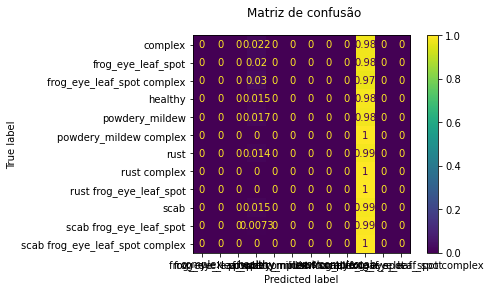

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)
#normalize{‘true’, ‘pred’, ‘all’}, default=None
disp = ConfusionMatrixDisplay.from_predictions(df_val_pred["labels"], prediction,normalize='true')
disp.figure_.suptitle("Matriz de confusão")
# print(f"Matriz de confusão:\n{disp.confusion_matrix}")
plt.show()


In [ ]:
# Matriz de confusão
cm = confusion_matrix(np.argmax(prediction, axis=1),  df_train_pred["labels"])
print("Matriz de confusão")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')